In [1]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
base_path = '/home/sanjeev/ML_Dataset/Malimg_data' # Data Path 
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [4]:
# classes in malimg data
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [5]:
# Get the current working directory
cur_dir = os.getcwd()
os.chdir(base_path)  # Navigate to the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted([f for f in os.listdir(os.getcwd()) if os.path.isdir(f)], key=str.lower)  # Only directories
no_imgs = []  # Number of samples per family

for fam in list_fams:
    os.chdir(fam)
    len1 = len(glob.glob('*.png'))  # Assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # Total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i, no_img in enumerate(no_imgs):
    print("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], no_img))
    for _ in range(no_img):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

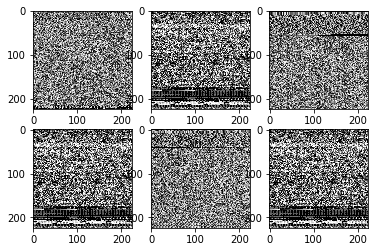

In [6]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [7]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add a global average pooling layer to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
base_model.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Set the output shape of the model to (None, 1024)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
data_labels = set(categories)
image_path = list(paths.list_images(base_path))
images = []                                                   # appending trainable features from MobileNetV1
labels = []                                                   # appending trainable lables from MobileNetV1
img_width = 224                                               # Image size
img_height = 224

In [13]:
# for img in image_path:
#     label = img.split(os.path.sep)[-2]
#     image = cv2.imread(img)                                    # Reading images using CV2
#     rezise_image = cv2.resize(image, (img_width, img_height))  # Resizing Images
#     x = np.expand_dims(rezise_image, axis=0)                   # Converting x into 1-D array
#     x = preprocess_input(x)
    
#     ##features extracted from mobilenetv2 global avg pooling layer
#     features = model.predict(x)                                # Predicting features of X
#     images.append(features)                                    # Appending features to train_features
#     labels.append(label)

In [14]:
# x = np.concatenate(images, axis=0)
# y = np.array(labels)

In [15]:
# x.shape

In [16]:
# len(images)

In [17]:
#load the saved features

In [18]:
features = np.load('/home/sanjeev/DL_Exp_Malware/Mobilenet_poc/Adversarial_Attacks_Testing/MobileNet_V3_large_trainable_features.npy')  
labels = np.load('/home/sanjeev/DL_Exp_Malware/Mobilenet_poc/Adversarial_Attacks_Testing/MobileNet_V3_large_trianable_labels.npy') 

In [19]:
print(features.shape)
print(labels.shape)

(9340, 960)
(9340,)


In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
int_labels = label_encoder.fit_transform(labels)

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_labels = one_hot_encoder.fit_transform(int_labels.reshape(-1, 1))

print("One-hot label shape:", one_hot_labels.shape)  # Should be (9340, num_classes)

One-hot label shape: (9340, 26)


In [25]:
print("Number of images:", len(images))
print("Number of labels:", len(labels))


Number of images: 3934
Number of labels: 9340


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, one_hot_labels, test_size=0.2, random_state=42
)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(960,)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Number of classes in the dataset
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               492032    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 26)                6682      
                                                                 
Total params: 630,042
Trainable params: 630,042
Non-trainable params: 0
_________________________________________________________________


In [30]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Train on 5977 samples, validate on 1495 samples
Epoch 1/30
5977/5977 [==============================] - 2s 269us/sample - loss: 0.7431 - accuracy: 0.8056 - val_loss: 0.1845 - val_accuracy: 0.9438
Epoch 2/30
5977/5977 [==============================] - 1s 147us/sample - loss: 0.2362 - accuracy: 0.9307 - val_loss: 0.1103 - val_accuracy: 0.9632
Epoch 3/30
5977/5977 [==============================] - 1s 150us/sample - loss: 0.1724 - accuracy: 0.9463 - val_loss: 0.0906 - val_accuracy: 0.9692
Epoch 4/30
5977/5977 [==============================] - 1s 150us/sample - loss: 0.1530 - accuracy: 0.9530 - val_loss: 0.0941 - val_accuracy: 0.9632
Epoch 5/30
5977/5977 [==============================] - 1s 149us/sample - loss: 0.1241 - accuracy: 0.9580 - val_loss: 0.0826 - val_accuracy: 0.9732
Epoch 6/30
5977/5977 [==============================] - 1s 148us/sample - loss: 0.1202 - accuracy: 0.9612 - val_loss: 0.0900 - val_accuracy: 0.9652
Epoch 7/30
5977/5977 [==============================] - 1s 149us

In [33]:
model.save('malware_classifier_adv.h5')

In [34]:
import sys
sys.setrecursionlimit(3000)

In [37]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod

In [38]:
# Define the KerasClassifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [39]:
# Initialize the FGSM (Fast Gradient Sign Method) attack
attack = FastGradientMethod(estimator=classifier, eps=0.1)

In [40]:
X_test_adv = attack.generate(X_test) 

In [41]:
# Test classifier on adversarial examples
y_pred_adv = classifier.predict(X_test_adv)
y_pred_labels = np.argmax(y_pred_adv, axis=1)
y_true_labels = np.argmax(y_test, axis=1) 

In [42]:
adv_accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"Adversarial Accuracy: {adv_accuracy * 100:.2f}%")

Adversarial Accuracy: 70.82%


In [43]:
# Optionally, evaluate on clean test data to compare
y_pred_clean = classifier.predict(X_test)  # Original (clean) test data
y_pred_clean_labels = np.argmax(y_pred_clean, axis=1)

In [44]:
clean_accuracy = np.mean(y_pred_clean_labels == y_true_labels)
print(f"Clean Test Accuracy: {clean_accuracy * 100:.2f}%")

Clean Test Accuracy: 98.39%


In [45]:
eps_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 1.5]  # List of epsilon values to test

In [46]:
results = []

In [47]:
for eps in eps_values:
    print(f"Testing with eps = {eps}")
    # Initialize FGSM attack with current epsilon
    attack = FastGradientMethod(estimator=classifier, eps=eps)
    
    # Generate adversarial examples
    X_test_adv = attack.generate(X_test)
    
    # Predict on adversarial examples
    y_pred_adv = classifier.predict(X_test_adv)
    y_pred_labels = np.argmax(y_pred_adv, axis=1)
    adv_accuracy = np.mean(y_pred_labels == y_true_labels)
    print(f"Epsilon: {eps}, Adversarial Accuracy: {adv_accuracy * 100:.2f}%")
    
    results.append((eps, adv_accuracy * 100))

# Optionally, print a summary
print("\nSummary of Results:")
for eps, adv_acc in results:
    print(f"Epsilon: {eps:.2f}, Adversarial Accuracy: {adv_acc:.2f}%")

Testing with eps = 0.01
Epsilon: 0.01, Adversarial Accuracy: 98.39%
Testing with eps = 0.05
Epsilon: 0.05, Adversarial Accuracy: 85.28%
Testing with eps = 0.1
Epsilon: 0.1, Adversarial Accuracy: 70.82%
Testing with eps = 0.2
Epsilon: 0.2, Adversarial Accuracy: 29.01%
Testing with eps = 0.3
Epsilon: 0.3, Adversarial Accuracy: 9.58%
Testing with eps = 0.5
Epsilon: 0.5, Adversarial Accuracy: 1.39%
Testing with eps = 0.6
Epsilon: 0.6, Adversarial Accuracy: 0.80%
Testing with eps = 1.5
Epsilon: 1.5, Adversarial Accuracy: 0.43%

Summary of Results:
Epsilon: 0.01, Adversarial Accuracy: 98.39%
Epsilon: 0.05, Adversarial Accuracy: 85.28%
Epsilon: 0.10, Adversarial Accuracy: 70.82%
Epsilon: 0.20, Adversarial Accuracy: 29.01%
Epsilon: 0.30, Adversarial Accuracy: 9.58%
Epsilon: 0.50, Adversarial Accuracy: 1.39%
Epsilon: 0.60, Adversarial Accuracy: 0.80%
Epsilon: 1.50, Adversarial Accuracy: 0.43%


In [48]:
print(f"Data range: {X_train.min()} to {X_train.max()}")

Data range: -0.32770103216171265 to 12.780712127685547
